# Preamble

TODO

## Setup
### Imports



In [960]:
import itertools
import unicodedata
import re
import os
from pathlib import Path
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import matplotlib
from  matplotlib.ticker import FuncFormatter
import networkx as nx

### Helper Functions

In [1269]:
def contingency_statistics(contingency):
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    association = scipy.stats.contingency.association(contingency)
    return {
        "χ²": chi2,
        "p-value": p,
        "df": dof,
        "V": association
    }

def chi2_deluxe(xtab):
    chi2_stat, p, dof, expected = scipy.stats.contingency.chi2_contingency(xtab)
    chi2_contributions = (xtab - expected) ** 2 / expected
    p_values = chi2_contributions.apply(lambda chi2: scipy.stats.chi2.sf(chi2, df=1))
    num_cells = xtab.size  # Total number of cells (rows * columns)
    def mark_significance(p_value):
        correction = num_cells  # Use the number of cells for Bonferroni correction
        if p_value < 0.001 / correction:
            return '***'
        elif p_value < 0.01 / correction:
            return '**'
        elif p_value < 0.05 / correction:
            return '*'
        else:
            return 'n. s.'
    significance = p_values.map(mark_significance)
    signs = np.sign(xtab - expected).map(lambda x: "+" if x > 0 else "–")
    results = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    
    for row in xtab.index:
        for col in xtab.columns:
            chi2_value = chi2_contributions.loc[row, col]
            sign = signs.loc[row, col]
            p_value = p_values.loc[row, col]
            sig = significance.loc[row, col]
            results.loc[row, col] = f"{sign}, χ² = {chi2_value:.2f} {sig}"

    return results


### Style

In [1353]:
pd.set_option("styler.format.decimal", ".")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

plt.rcParams['svg.fonttype'] = 'none' # ref https://stackoverflow.com/a/35734729

sns.set_style("ticks")
sns.set_context("paper")
cm = plt.cm.Blues

font_dir = "/nix/var/nix/profiles/system/sw/share/X11/fonts"
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[font_dir])
matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Junicode-Regular.ttf")
matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Antinoou.ttf")

plt.rcParams["font.family"] = ["Junicode", "Antinoou"]

### Assets Export

Finally, we want to set up functions for writing tables and figures to external files, so they can be included in a document.

In [964]:
subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")


def write_csv(df, the_name):
    df.to_csv(subdirectory / (the_name + '.csv'))  

def write_table(df, the_name, caption="", heatmap=False, as_ints=False, axis=None):
    style = df.style.format(precision=0, na_rep="–") if as_ints else df.style
    style = style if not heatmap else style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

# Data overview

In [1247]:
df_attestations = pd.read_csv("attestations.csv")

/tmp/ipykernel_421023/109604783.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_attestations = pd.read_csv("attestations.csv")


In [1248]:
df_diff = pd.read_csv("deviations.csv")

In [1249]:
df_diff["dialect_group"] = pd.Categorical(df_diff["dialect_group"], list("BFMSLA"))
df_attestations["dialect_group"] = pd.Categorical(df_attestations["dialect_group"], list("BFMSLA"))

In [1250]:
df_attestations.groupby("dialect_group").agg({
    "manuscript_text": ['nunique'],
    "greek_lemma": ['count', 'nunique'],
    "latest": ['min', 'median', 'max'],
    "earliest": ['min', 'median', 'max'],
})

/tmp/ipykernel_421023/3285678043.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_attestations.groupby("dialect_group").agg({


manuscript_text greek_lemma         latest                 \
                      nunique       count nunique    min median     max   
dialect_group                                                             
B                          39        9181    1109  399.0  999.0  1249.0   
F                          69        3405     571  349.0  799.0  1199.0   
M                          19        8421     683  433.0  499.0   599.0   
S                        2914      160092    4401  399.0  874.0  1299.0   
L                         130        8358     956  299.0  399.0   499.0   
A                          26        5589     611  399.0  399.0   599.0   

              earliest                 
                   min median     max  
dialect_group                          
B                300.0  800.0  1200.0  
F                200.0  500.0  1000.0  
M                364.0  400.0   500.0  
S                200.0  700.0  1100.0  
L                200.0  350.0   375.0  
A                300.0  300.0   400.0

# Is there an influence of era on spelling accuracy?

In [1256]:
df_attestations["accuracy"] = df_attestations.dropna(subset=["greek_lemma", "orthography_clean"]).apply(lambda row: SequenceMatcher(None, row["greek_lemma"], row["orthography_clean"]).ratio(), axis=1)

In [1257]:
df_attestations["era"] = df_attestations["date_approximate"].apply(lambda date: None if math.isnan(date) else "pre-chalcedon" if date < 451 else "post-chalcedon" if date < 642 else "arab")

In [1258]:
group_early = df_attestations[df_attestations["era"] == "pre-chalcedon"]["accuracy"].values
group_mid = df_attestations[df_attestations["era"] == "post-chalcedon"]["accuracy"].values
group_late = df_attestations[df_attestations["era"] == "arab"]["accuracy"].values

group_early = group_early[~np.isnan(group_early)]
group_mid = group_mid[~np.isnan(group_mid)]
group_late = group_late[~np.isnan(group_late)]

# Perform Mann-Whitney U test between groups
# Example: early vs mid
statistic_early_mid, p_value_early_mid = scipy.stats.mannwhitneyu(group_early, group_mid, alternative='two-sided')

# Example: early vs late
statistic_early_late, p_value_early_late = scipy.stats.mannwhitneyu(group_early, group_late, alternative='two-sided')

# Example: mid vs late
statistic_mid_late, p_value_mid_late = scipy.stats.mannwhitneyu(group_mid, group_late, alternative='two-sided')

# Output the results
print(f"Early vs Mid: U-statistic: {statistic_early_mid}, P-value: {p_value_early_mid}")
print(f"Early vs Late: U-statistic: {statistic_early_late}, P-value: {p_value_early_late}")
print(f"Mid vs Late: U-statistic: {statistic_mid_late}, P-value: {p_value_mid_late}")

Early vs Mid: U-statistic: 109804308.0, P-value: 2.545452012247549e-80
Early vs Late: U-statistic: 843790340.0, P-value: 0.0
Mid vs Late: U-statistic: 169067720.0, P-value: 9.940305053050596e-05


<Axes: xlabel='era', ylabel='accuracy'>

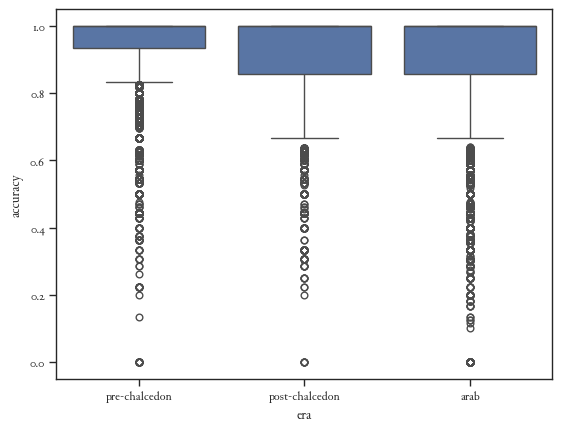

In [1259]:
sns.boxplot(df_attestations, y="accuracy", x="era")
#plt.yscale("log")

# How does the rate of deviations develop across time?

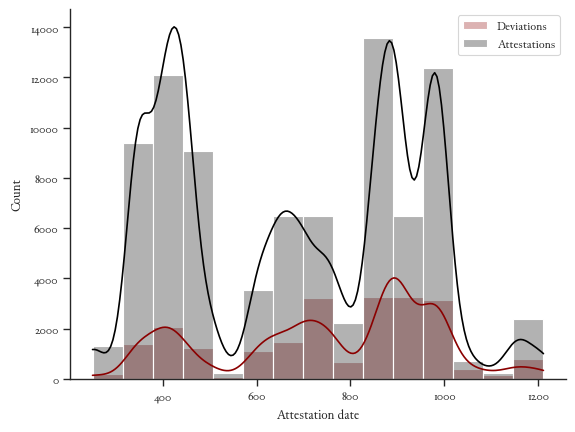

In [1260]:
sns.histplot(
    data=df_diff,
    x='date_approximate',
    bins=15,
    kde=True,
    color='darkred',
    label='Deviations',
    alpha=0.3
)

sns.histplot(
    data=df_attestations,
    x='date_approximate',
    bins=15,
    kde=True,
    color='black',
    label='Attestations',
    alpha=0.3
)

# Styling
sns.despine(trim=False)
plt.legend()
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_deviations")

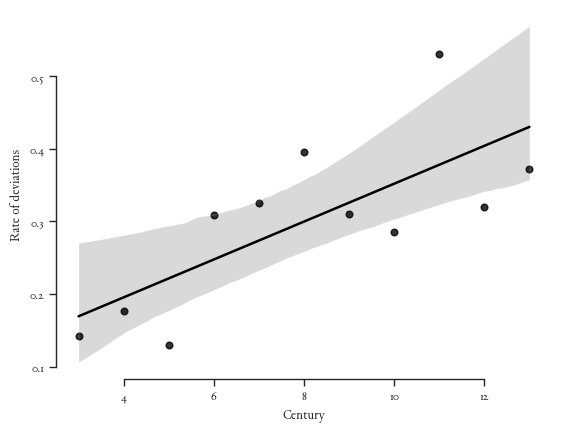

In [1267]:
ratios = df_diff["century"].value_counts() / df_attestations["century"].value_counts()
ratios_df = ratios.reset_index()
ratios_df.columns = ["Century", "Rate of deviations"]
sns.regplot(ratios_df, x="Century", y="Rate of deviations", color="black")
sns.despine(trim=True)
write_figure("attestations_by_deviations")

# How does the rate of deviations behave across dialects?

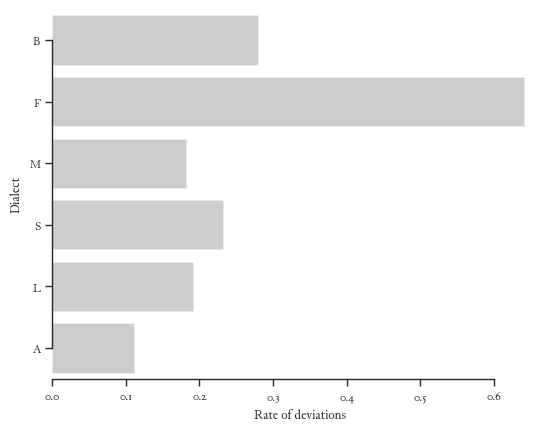

In [1268]:
dialect_ratios = df_diff["dialect_group"].value_counts() / df_attestations["dialect_group"].value_counts()
dialect_ratios_df = dialect_ratios.reset_index()
dialect_ratios_df.columns = ["Dialect", "Rate of deviations"]
sns.barplot(dialect_ratios_df, x="Rate of deviations", y="Dialect", color="black", alpha=0.2)
sns.despine(trim=True)
write_figure("deviations_by_dialect")

# Grouping deviations

In [1309]:
morphological_lapsus = {"∅→ⲥ", "∅→ⲓ", "∅→", "∅→", "∅→ⲏ", "∅→ⲕ", "∅→ⲧ", "∅→ⲡ", "∅→ⲣ", "∅→ⲟⲥ", "∅→ⲟⲩ", "ⲏ→ⲁ"}

deviation_operates_in = lambda graphemes: lambda deviation: deviation["norm"] in graphemes and deviation["var"] in graphemes

def classify(deviation):
    norm, var = deviation["norm"], deviation["var"]
    operates_in = lambda graphemes: deviation_operates_in(graphemes)(deviation)
    if operates_in({"ⲧ", "ⲇ"}) or operates_in({"ⲕ", "ⲅ"}) or operates_in({"ⲃ", "ⲡ"}) or operates_in({"ⲥ", "ⲍ"}):
        return "voiced_voiceless", "nongreek"
    elif operates_in({"ⲗ", "ⲣ"}):
        return "lambdacism", "nongreek"
    elif operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲫ", "ⲡ"}) or operates_in({"ⲭ", "ⲕ"}):
        return "aspiration", "nongreek"
    elif operates_in({"∅", "ϩ"}):
        return "aspiration", "greek"
    elif operates_in({"ⲁⲓ", "ⲉ"}) or operates_in({"ⲱ", "ⲱⲓ"}) or operates_in({"ⲏⲓ", "ⲏ"}) or operates_in({"ⲏⲓ", "ⲓ"}) or operates_in({"ⲟⲓ", "ⲩ"}):
        return "monophthongization", "greek"
    elif operates_in({"ⲉⲓ", "ⲓ"}):
        return "front_vowel", "greek"
    elif operates_in({"ⲟ", "ⲱ"}):
        return "back_vowel", "greek"
    elif operates_in({"ⲟⲓ", "ⲉ"}) or operates_in({"ⲁⲓ", "ⲁ"}) or operates_in({"ⲩⲓ", "ⲩ"}):
        return "monophthongization", "nongreek"
    elif operates_in({"ⲟ", "ⲱ", "ⲟⲩ", "ⲱⲓ"}) or operates_in({"ⲁ", "ⲟ"}): # ôi ~ ô already attributed to monophthongisation
        return "back_vowel", "nongreek"
    elif operates_in({"ⲏ", "ⲉ", "ⲩ", "ⲉⲓ", "ⲓ", "ⲟⲓ", "ⲁⲓ"}) or operates_in({"ⲁ", "ⲉ"}): # ai/oi ~ e already attributed to monophthongisation
        return "front_vowel", "nongreek"
    elif operates_in({"ⲛ", "∅"}) or operates_in({"ⲙ", "∅"}) or operates_in({"ⲅ", "ⲛ"}):
        return "nasal", "nongreek"
    elif operates_in({"ⲕ", "ϭ"}) or operates_in({"ϩ", "ϣ"}) or operates_in({"ⲭ", "ϫ"}):
        return "palatalisation", "nongreek"
    elif norm == 2 * var or var == 2 * norm:
        return "gemination", "greek"
    elif operates_in({"ⲉ", "∅"}) or operates_in({"ⲓ", "∅"}) or operates_in({"ⲁ", "∅"}) or operates_in({"ⲟ", "∅"}) or operates_in({"ⲩ", "∅"}):
        return "epenthesis", "nongreek"
    elif norm == "ⲟ" and var == "ⲉ":
        return "reduction", "nongreek"
    elif operates_in({"ϥ", "ⲃ"}):
        return "spirantisation", "nongreek"
    else:
        return None, None

df_diff[["shift_class", "shift_origin"]] = df_diff.apply(classify, axis=1, result_type='expand')

### Statistical Prerequisites: Regularity

We define the *regularity* of an orthographic deviation to be its absolute frequency (how often it did appear) divided by the frequency with which the input appears in all Greek lemmata (how often it *could* appear).

Note that the *regularity* of an insertion is undefined. We cannot count the frequency of its input, i.e. the empty string.

# What influences (de-)geminations?

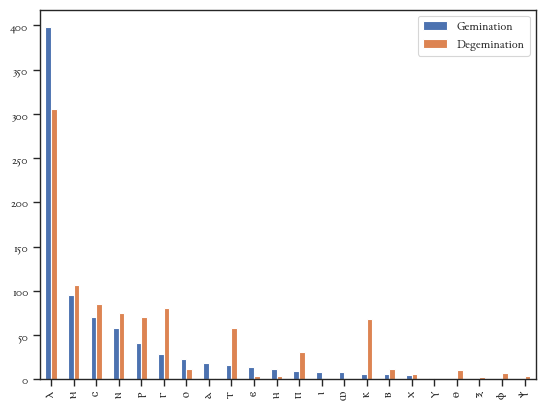

In [1273]:
geminations = df_diff[(df_diff["norm"] * 2 == df_diff["var"])]
degeminations = df_diff[(df_diff["norm"] == df_diff["var"] * 2)]

interesting = vowels | consonants

geminate_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x * 2).sum() for x in interesting})

gemination_occurrences = geminations[geminations["norm"].isin(interesting)]["norm"].value_counts()
degemination_occurrences = degeminations[degeminations["var"].isin(interesting)]["var"].value_counts()

pd.DataFrame({
    "Gemination": gemination_occurrences,
    "Degemination": degemination_occurrences,
}).sort_values(by="Gemination", ascending=False).plot.bar()
write_figure("gemination_degemination")

/tmp/ipykernel_421023/3466280920.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x=x[1], y=x[0], s=key)


SignificanceResult(statistic=0.7108169694791018, pvalue=0.002024468518437725)

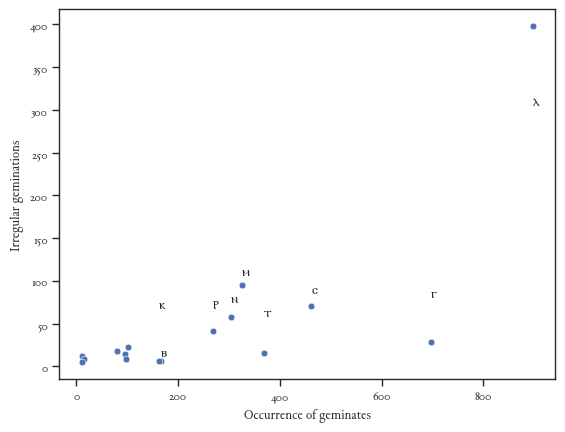

In [1302]:
degemination_vs_geminates = pd.DataFrame({
    "Degemination": degemination_occurrences,
    "Geminates": geminate_occurrences,
    "Gemination": gemination_occurrences,
}).dropna()
ax = sns.scatterplot(degemination_vs_geminates, y="Gemination", x="Geminates")
plt.ylabel("Irregular geminations")
plt.xlabel("Occurrence of geminates")
for key, x in degemination_vs_geminates.iterrows():
    if any([n>=150 for n in x]):
        ax.text(x=x[1], y=x[0], s=key)
#plt.yscale("log")
scipy.stats.spearmanr(degemination_vs_geminates["Geminates"], degemination_vs_geminates["Gemination"])

## Is Bohairic different?

In [1303]:
x_gem = geminations[geminations["norm"].isin(interesting)]
x_deg = degeminations[degeminations["var"].isin(interesting)]

x_gem_deg = pd.concat([x_gem, x_deg])

#pd.crosstab(x_gem_deg["deviation"], x_gem_deg["dialect_group"]).sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)
xtab_gem = pd.crosstab(df_diff.shift_class == "gemination", df_diff.dialect_group == "B").rename(
    columns={
        True: 'B',  # Rename True to 'Group B'
        False: 'F/M/S/L/A'    # Rename False to 'Other'
    },
    index={
        True: 'Gemination deviation',  # Rename True to 'Aspiration & Non-Greek'
        False: 'Other deviation'        # Rename False to 'Other Combinations'
    }
)
expected = scipy.stats.contingency.chi2_contingency(xtab_gem).expected_freq

print(contingency_statistics(xtab_gem))

xtab_gem

{'χ²': 0.0005143259782316011, 'p-value': 0.9819065216540869, 'df': 1, 'V': 0.0003493550651085073}


dialect_group,F/M/S/L/A,B
shift_class,,
Other deviation,41499,2466
Gemination deviation,1713,101


# Vowel alternations

In [1354]:
df_diff_vocalic = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)]
vowel_frequency_data = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"])

unique_labels = list(set(vowel_frequency_data.index).union(set(vowel_frequency_data.columns)))

vowel_frequency = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

vowel_frequency.update(vowel_frequency_data)

write_table(vowel_frequency, "vowel_frequency", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Häufigkeit")
vowel_frequency.style.background_gradient(axis=None, cmap=cm)

,ⲏ,ⲉⲩ,ⲩⲓ,ⲏⲓ,ⲩ,ⲉⲓ,ⲉ,ⲁⲩ,ⲁⲓ,ⲟⲓ,ⲟ,ⲓ,ⲱ,ⲟⲩ,ⲱⲓ,ⲁ,ⲏⲩ
ⲏ,0,5,0,4,1080,71,900,1,7,30,18,607,10,7,0,70,12
ⲉⲩ,9,0,0,0,7,0,39,2,7,1,5,4,3,7,0,3,6
ⲩⲓ,3,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0
ⲏⲓ,68,0,0,0,6,0,2,0,0,0,0,19,0,0,0,0,0
ⲩ,527,4,0,0,0,7,314,0,9,10,27,239,6,29,0,26,1
ⲉⲓ,73,0,0,0,25,0,130,0,8,14,0,4784,1,0,0,22,0
ⲉ,379,3,0,0,318,100,0,0,141,8,18,253,4,2,0,96,0
ⲁⲩ,0,1,0,0,2,0,0,0,0,0,0,0,1,0,0,6,0
ⲁⲓ,87,0,1,0,40,37,1448,1,0,14,5,29,3,0,0,341,0
ⲟⲓ,80,0,0,0,21,18,193,0,36,0,12,77,2,1,6,0,0


In [1355]:
vowel_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs})

vowel_regularity = vowel_frequency.div(vowel_occurrences, axis="rows").fillna(0)
write_table(vowel_regularity, "vowel_regularity", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Regelmäßigkeit")
vowel_regularity.style.background_gradient(axis=None, cmap=cm)

,ⲏ,ⲉⲩ,ⲩⲓ,ⲏⲓ,ⲩ,ⲉⲓ,ⲉ,ⲁⲩ,ⲁⲓ,ⲟⲓ,ⲟ,ⲓ,ⲱ,ⲟⲩ,ⲱⲓ,ⲁ,ⲏⲩ
ⲁ,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
ⲁⲓ,0.02,0.00,0.00,0.00,0.01,0.01,0.32,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.07,0.00
ⲁⲩ,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
ⲉ,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
ⲉⲓ,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.59,0.00,0.00,0.00,0.00,0.00
ⲉⲩ,0.01,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01
ⲏ,0.00,0.00,0.00,0.00,0.07,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00
ⲏⲓ,0.67,0.00,0.00,0.00,0.06,0.00,0.02,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00
ⲏⲩ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ⲓ,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


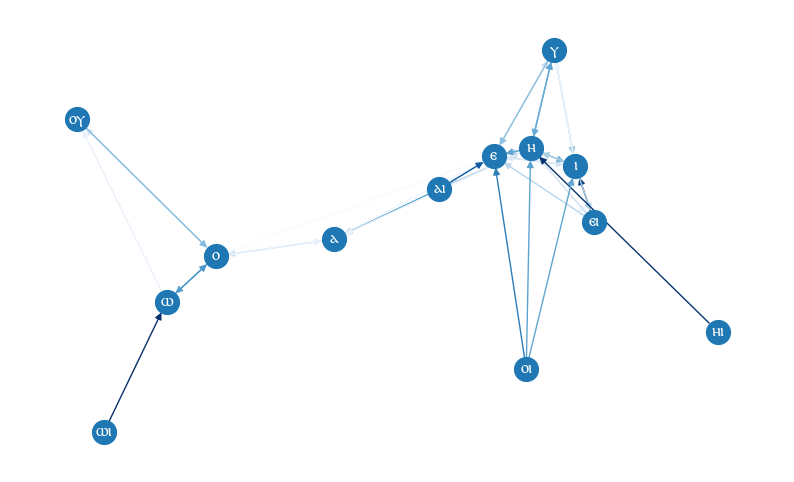

In [1364]:
all_vowel_regularities = vowel_regularity.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "regularity"})
all_vowel_frequencies = vowel_frequency.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "frequency"})
vowel_deviations = pd.merge(all_vowel_regularities, all_vowel_frequencies, on=["norm", "var"])

fig = plt.figure(figsize=(10, 6))

graph = nx.from_pandas_edgelist(
    vowel_deviations[vowel_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["regularity", "frequency"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, weight="frequency", seed=6)

nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(v) for v in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)

fig.savefig(subdirectory / "figure-vowels_graph.svg")
plt.show()

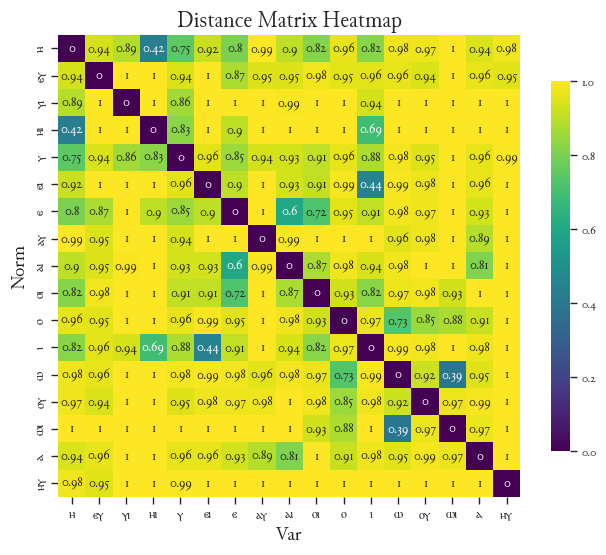

/tmp/ipykernel_421023/56228725.py:35: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


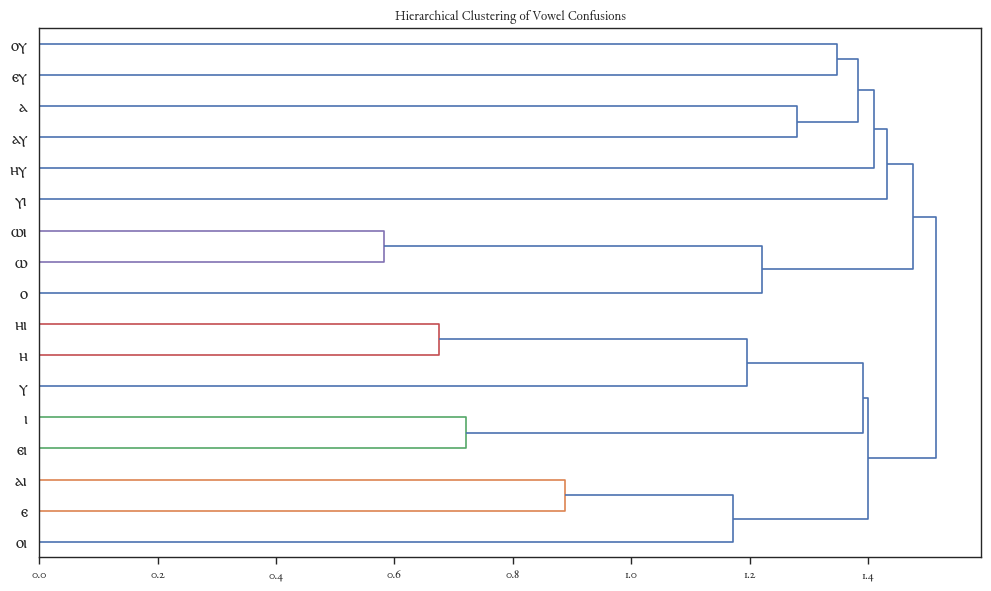

In [1366]:
# Make a copy to avoid modifying original
norm_confusion = vowel_frequency.copy().astype(float)

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in vowel_occurrences:
        total = vowel_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Vowel Confusions")
plt.tight_layout()
plt.show()


(300.0, 1272.6)

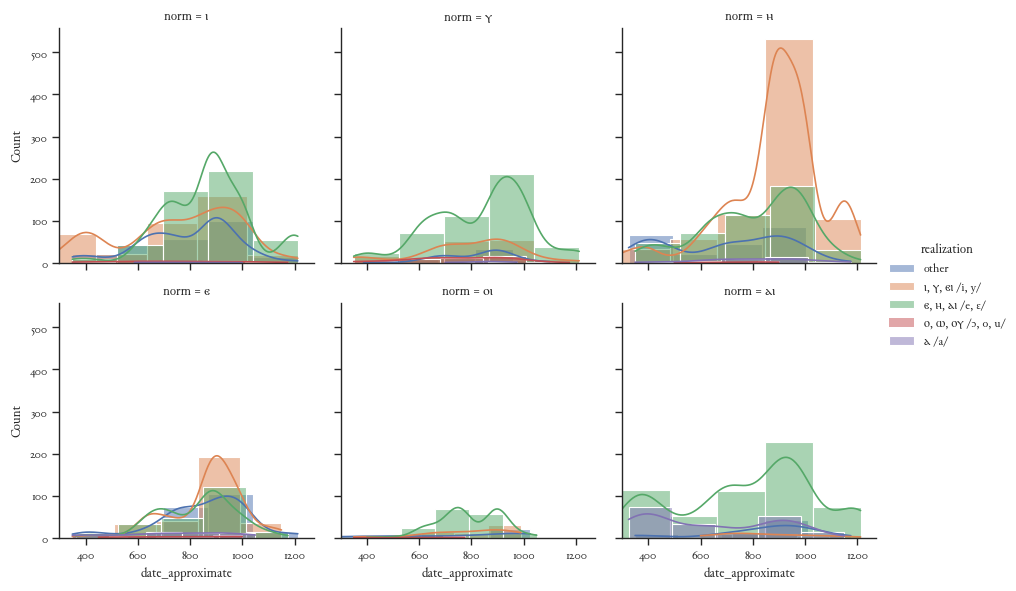

In [1511]:
front_vowels = df_diff[df_diff["norm"].isin({"ⲟⲓ", "ⲏ", "ⲩ", "ⲁⲓ", "ⲉ", "ⲓ"})].copy()
front_vowels["realization"] = front_vowels["var"].apply(lambda x: "ⲓ, ⲩ, ⲉⲓ /i, y/" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "ⲉ, ⲏ, ⲁⲓ /e, ɛ/" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "ⲟ, ⲱ, ⲟⲩ /ɔ, o, u/" if x in {"ⲟⲩ", "ⲟ", "ⲱ"} else "ⲁ /a/" if x in {"ⲁ"} else "other")

g = sns.FacetGrid(front_vowels, col="norm", hue="realization", col_wrap=3, col_order=["ⲓ", "ⲩ", "ⲏ", "ⲉ", "ⲟⲓ", "ⲁⲓ"])
g.map(sns.histplot, "date_approximate", kde=True, bins=5)
g.add_legend()
plt.xlim(300)

## Diphthongs

<Axes: xlabel='date_approximate', ylabel='Count'>

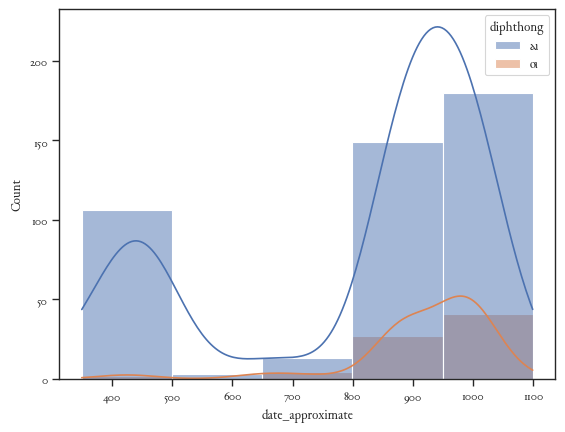

In [1442]:
spelling_pronunciation = df_attestations[
    (df_attestations["greek_lemma"].str.contains("ⲟⲓ") & df_attestations["orthography"].str.contains("ⲟⲓ̈"))
    | (df_attestations["greek_lemma"].str.contains("ⲁⲓ") & df_attestations["orthography"].str.contains("ⲁⲓ̈"))
].copy()
spelling_pronunciation["diphthong"] = spelling_pronunciation["orthography"].apply(lambda x: "ⲟⲓ" if "ⲟⲓ̈" in x else "ⲁⲓ" if "ⲁⲓ̈" in x else "?")
sns.histplot(data=spelling_pronunciation, x='date_approximate', hue='diphthong', bins=5, kde=True)

<https://kmein.github.io/greek-coptic-dashboard/?orthography_regex=%E2%B2%81%E2%B2%93%CC%88|%E2%B2%9F%E2%B2%93%CC%88&greek_lemma_regex=%E2%B2%81%E2%B2%93|%E2%B2%9F%E2%B2%93>

In [1449]:
spelling_pronunciation.sample(10)["orthography"]

120086        ⲓ̈|ⲟⲩⲇⲁⲓ̈
137537    ⲟⲓ̈ⲕⲟⲛ[ⲟⲙⲉⲓ̄]
125568       ⲇⲁⲓ̈ⲙⲟⲛⲓⲟⲛ
157220          ⲗⲟⲓ̈ⲡⲟⲛ
123791         ⲡⲁⲓ̈ⲇⲉⲩⲉ
120006           ⲭⲁⲓ̈ⲣⲉ
134672     ⲕⲟⲓ̈ⲛ[ⲱ]ⲛⲉⲓ̈
149869       ⲟⲓ̈ⲕⲟⲛⲟⲙⲟⲥ
158150      ⲇⲁⲓ̈ⲙⲱⲛⲓ̈ⲟⲛ
18695           ⲁⲓ̈[ⲱⲛ]
Name: orthography, dtype: object

## What influences ⲁ-vowel deviation?

In [958]:
def categorize(row):
    if row['norm'] in {"ⲁ", "ⲟ"} and row['var'] in {"ⲁ", "ⲟ"}:
        return "ⲁ/ⲟ"
    elif row['norm'] == "ⲉ" and row['var'] in {"ⲁ", "ⲉ"}:
        return "ⲉ/ⲁ"
    else:
        return "other"
        
xtab_vocalism = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].isin({"F", "L", "A"})
).rename(
    columns={False: "S/B", True: "F/M/L/A"}
)

# Print the contingency statistics
print(contingency_statistics(xtab_vocalism))
xtab_vocalism

{'χ²': 27.312385914032827, 'p-value': 1.1727103414571343e-06, 'DOF': 2, 'V': 0.02442568034617208}


dialect_group,S/B,F/M/L/A
row_0,,
other,40777,4407
ⲁ/ⲟ,485,14
ⲉ/ⲁ,86,10


In [635]:
chi2_deluxe(xtab_vocalism)

dialect_group,S/B,F/M/L/A
row_0,,
other,"–, χ² = 0.03 n. s.","+, χ² = 0.26 n. s."
ⲁ/ⲟ,"+, χ² = 2.61 n. s.","–, χ² = 24.36 ***"
ⲉ/ⲁ,"–, χ² = 0.01 n. s.","+, χ² = 0.05 n. s."


## Coarticulation

In [1138]:
def place_of_articulation(x):
    if x in {"ⲃ", "ⲡ", "ⲫ", "ⲙ", "ⲯ"}:
        return "labial"
    elif x in {"ⲅ", "ⲕ", "ⲭ", "ⲝ"}:
        return "velar"
    elif x in {"ⲇ", "ⲧ", "ⲑ", "ⲗ", "ⲛ", "ⲣ", "ⲥ", "ⲍ"}:
        return "alveolar"
    else:
        return None


def compare_vowels(vowel1, vowel2, strata):
    # Create a mapping of vowels to their stratum index
    stratum_index = {vowel: index for index, stratum in enumerate(strata) for vowel in stratum}
    
    # Get the indices of the vowels
    index1 = stratum_index.get(vowel1)
    index2 = stratum_index.get(vowel2)
    
    # Compare the indices
    if index1 is None or index2 is None:
        return None  # Return None if one or both vowels are not found
    elif index1 < index2:
        return -1  # vowel1 is in an earlier stratum
    elif index1 > index2:
        return +1  # vowel1 is in a later stratum
    else:
        return 0  # Both vowels are in the same stratum

# assuming early koine inventory
vowel_height = [["ⲓ", "ⲉⲓ", "ⲟⲩ", "ⲏ", "ⲟⲓ", "ⲩ"], ["ⲁⲓ", "ⲉ", "ⲟ", "ⲱ"], ["ⲁ"]]
vowel_frontness = [["ⲓ", "ⲉⲓ", "ⲩ", "ⲟⲓ", "ⲏ"], ["ⲁⲓ", "ⲉ"], ["ⲁ"], ["ⲟ", "ⲱ"], ["ⲟⲩ"]]
vowel_roundness = [["ⲓ", "ⲉⲓ", "ⲏ", "ⲁⲓ", "ⲉ", "ⲁ"], ["ⲩ", "ⲟⲓ", "ⲟ", "ⲟⲩ", "ⲱ"]]

def process_height(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_height)
    if comparison is not None:
        if comparison < 0:
            return "lowering"
        elif comparison > 0:
            return "raising"
        else:
            #print(comparison, row["norm"], row["var"])
            return "none"

def process_frontness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_frontness)
    if comparison is not None:
        if comparison < 0:
            return "backing"
        elif comparison > 0:
            return "fronting"
        else:
            return "none"

def process_roundness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_roundness)
    if comparison is not None:
        if comparison < 0:
            return "unrounding"
        elif comparison > 0:
            return "rounding"
        else:
            return "none"

x = df_diff[(df_diff["norm"].isin(vowels|diphthongs)) & df_diff["var"].isin(vowels | diphthongs) & (df_diff["context_right"] != "#")].copy()
x["environment_left"] = x.apply(lambda row: place_of_articulation(row.context_left[-1]), axis=1)
x["environment_right"] = x.apply(lambda row: place_of_articulation(row.context_right[0]), axis=1)
x["environment"] = x["environment_left"] + "…" + x["environment_right"]

### Raising / Lowering

In [1139]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_height, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'χ²': 85.42974175220981, 'p-value': 2.8129841383091787e-19, 'DOF': 2, 'V': 0.06859153798516616}


col_0,lowering,none,raising
row_0,,,
non-rhotic environment,1857,10570,1538
rhotic environment,696,2877,620


In [1140]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-rhotic environment,"–, χ² = 5.77 n. s.","+, χ² = 5.03 n. s.","–, χ² = 8.92 *"
rhotic environment,"+, χ² = 19.23 ***","–, χ² = 16.76 ***","+, χ² = 29.71 ***"


In [1141]:
xtab_nasal_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲙ", "ⲛ"})), x.apply(process_height, axis=1)).rename(
    index={True: "after nasal", False: "after non-nasal"}
)
print(contingency_statistics(xtab_nasal_coarticulation))
xtab_nasal_coarticulation

{'χ²': 243.55343231279045, 'p-value': 1.2973111447556762e-53, 'DOF': 2, 'V': 0.11581454925901047}


col_0,lowering,none,raising
context_left,,,
after non-nasal,2040,11933,1714
after nasal,513,1514,444


In [1142]:
chi2_deluxe(xtab_nasal_coarticulation)

col_0,lowering,none,raising
context_left,,,
after non-nasal,"–, χ² = 12.43 **","+, χ² = 8.59 *","–, χ² = 12.12 **"
after nasal,"+, χ² = 78.91 ***","–, χ² = 54.54 ***","+, χ² = 76.96 ***"


In [1143]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_height, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 127.653775571301, 'p-value': 1.906930379684372e-28, 'DOF': 2, 'V': 0.0838460921893284}


col_0,lowering,none,raising
row_0,,,
non-velar environment,2062,10068,1434
velar environment,491,3379,724


In [1144]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-velar environment,"+, χ² = 12.58 **","+, χ² = 0.05 n. s.","–, χ² = 19.66 ***"
velar environment,"–, χ² = 37.15 ***","–, χ² = 0.16 n. s.","+, χ² = 58.05 ***"


In [1145]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_height, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 95.12679550704132, 'p-value': 2.2053565562794494e-21, 'DOF': 2, 'V': 0.07237980815718631}


col_0,lowering,none,raising
row_0,,,
non-labial environment,1460,9032,1397
labial environment,1093,4415,761


In [1146]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-labial environment,"–, χ² = 26.78 ***","+, χ² = 5.88 n. s.","–, χ² = 0.18 n. s."
labial environment,"+, χ² = 50.79 ***","–, χ² = 11.15 **","+, χ² = 0.34 n. s."


In [1147]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_height, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 217.350295788818, 'p-value': 6.353059890145435e-48, 'DOF': 2, 'V': 0.10940725249645221}


col_0,lowering,none,raising
row_0,,,
non-alveolar environment,327,2590,163
alveolar environment,2226,10857,1995


In [1148]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-alveolar environment,"–, χ² = 25.97 ***","+, χ² = 41.89 ***","–, χ² = 112.63 ***"
alveolar environment,"+, χ² = 5.30 n. s.","–, χ² = 8.56 *","+, χ² = 23.01 ***"


### Fronting / Backing

In [1151]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_frontness, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'χ²': 87.225793448066, 'p-value': 1.145934020446696e-19, 'DOF': 2, 'V': 0.0693088125833279}


col_0,backing,fronting,none
row_0,,,
non-rhotic environment,2077,1486,10402
rhotic environment,860,493,2840


In [1152]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-rhotic environment,"–, χ² = 14.63 ***","–, χ² = 0.85 n. s.","+, χ² = 4.66 n. s."
rhotic environment,"+, χ² = 48.73 ***","+, χ² = 2.84 n. s.","–, χ² = 15.51 ***"


In [872]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 29.891083396711117, 'p-value': 3.2302319719687496e-07, 'DOF': 2, 'V': 0.040572972091817816}


col_0,backing,fronting,none
row_0,,,
non-velar environment,2255,1386,9923
velar environment,682,593,3319


In [873]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-velar environment,"+, χ² = 1.70 n. s.","–, χ² = 5.76 n. s.","+, χ² = 0.10 n. s."
velar environment,"–, χ² = 5.02 n. s.","+, χ² = 17.02 ***","–, χ² = 0.29 n. s."


In [874]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_frontness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 112.4547328308466, 'p-value': 3.808597112645329e-25, 'DOF': 2, 'V': 0.07869639951875763}


col_0,backing,fronting,none
row_0,,,
non-labial environment,1682,1271,8936
labial environment,1255,708,4306


In [875]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-labial environment,"–, χ² = 30.21 ***","–, χ² = 0.47 n. s.","+, χ² = 8.15 *"
labial environment,"+, χ² = 57.28 ***","+, χ² = 0.90 n. s.","–, χ² = 15.45 ***"


In [876]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 168.41521593008784, 'p-value': 2.6859660965408302e-37, 'DOF': 2, 'V': 0.09630673449592178}


col_0,backing,fronting,none
row_0,,,
non-alveolar environment,353,193,2534
alveolar environment,2584,1786,10708


In [877]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-alveolar environment,"–, χ² = 42.31 ***","–, χ² = 60.65 ***","+, χ² = 36.89 ***"
alveolar environment,"+, χ² = 8.64 *","+, χ² = 12.39 **","–, χ² = 7.54 *"


### Rounding / unrounding

In [878]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 257.4645936142004, 'p-value': 1.2367270330740168e-56, 'DOF': 2, 'V': 0.11907614079046773}


col_0,none,rounding,unrounding
row_0,,,
non-velar environment,10840,1420,1304
velar environment,3214,553,827


In [879]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-velar environment,"+, χ² = 11.12 **","–, χ² = 1.97 n. s.","–, χ² = 52.05 ***"
velar environment,"–, χ² = 32.83 ***","+, χ² = 5.80 n. s.","+, χ² = 153.69 ***"


In [880]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_roundness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 165.83100917452012, 'p-value': 9.778086920579488e-37, 'DOF': 2, 'V': 0.09556500039964118}


col_0,none,rounding,unrounding
row_0,,,
non-labial environment,9545,1106,1238
labial environment,4509,867,893


In [881]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-labial environment,"+, χ² = 12.79 **","–, χ² = 26.73 ***","–, χ² = 17.73 ***"
labial environment,"–, χ² = 24.26 ***","+, χ² = 50.69 ***","+, χ² = 33.62 ***"


In [882]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 37.28544864431695, 'p-value': 8.008804626403183e-09, 'DOF': 2, 'V': 0.045314342275202174}


col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,2430,381,269
alveolar environment,11624,1592,1862


In [883]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,"+, χ² = 0.89 n. s.","+, χ² = 6.42 n. s.","–, χ² = 23.65 ***"
alveolar environment,"–, χ² = 0.18 n. s.","–, χ² = 1.31 n. s.","+, χ² = 4.83 n. s."


# Consonant alternations

In [217]:
df_diff_consonantal = df_diff[df_diff["norm"].isin(consonants) & df_diff["var"].isin(consonants)]
consonant_frequency = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"])
consonant_frequency = consonant_frequency.loc[consonant_frequency.any(axis=1), consonant_frequency.any(axis=0)]
write_table(consonant_frequency, "consonant_frequency", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Häufigkeit")
consonant_frequency.style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
norm,,,,,,,,,,,,,,,,,,,,,,,
ϩ,69,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
ⲃ,0,22,0,0,0,0,0,0,0,0,1,0,16,1,0,30,0,0,0,0,0,0,0
ⲅ,0,0,1,0,15,0,0,0,2,0,801,2,2,212,0,1,3,0,2,2,3,0,0
ⲇ,0,0,0,8,0,1,1,0,0,0,0,0,0,13,0,0,0,6,1465,0,1,0,0
ⲍ,0,0,0,0,0,0,0,4,0,0,0,0,0,0,6,0,0,148,3,0,0,1,0
ⲑ,0,0,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,1,31,0,1,0,0
ⲕ,0,0,2,0,189,0,478,0,1,0,0,3,0,2,9,6,6,0,1,0,44,0,0
ⲗ,0,0,0,0,0,0,1,0,1,0,2,0,0,13,0,0,88,0,2,0,0,0,0
ⲙ,0,0,0,0,0,11,0,1,0,3,1,1,0,118,0,6,0,1,7,0,0,0,0


In [1370]:
consonant_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in consonants})

consonant_regularity = 100 * consonant_frequency.div(consonant_occurrences, axis="rows").fillna(0)
consonant_regularity = consonant_regularity.loc[consonant_regularity.any(axis=1), consonant_regularity.any(axis=0)]
write_table(consonant_regularity, "consonant_regularity", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Regelmäßigkeit")
consonant_regularity.style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
ϩ,1.76,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.05
ⲃ,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.70,0.04,0.00,1.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ⲅ,0.00,0.00,0.01,0.00,0.22,0.00,0.00,0.00,0.03,0.00,11.79,0.03,0.03,3.12,0.00,0.01,0.04,0.00,0.03,0.03,0.04,0.00,0.00
ⲇ,0.00,0.00,0.00,0.12,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.00,0.09,21.30,0.00,0.01,0.00,0.00
ⲍ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,8.59,0.17,0.00,0.00,0.06,0.00
ⲑ,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.73,0.00,0.02,0.00,0.00
ⲕ,0.00,0.00,0.02,0.00,1.77,0.00,4.48,0.00,0.01,0.00,0.00,0.03,0.00,0.02,0.08,0.06,0.06,0.00,0.01,0.00,0.41,0.00,0.00
ⲗ,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.12,0.00,0.00,0.84,0.00,0.02,0.00,0.00,0.00,0.00
ⲙ,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.01,0.00,0.02,0.01,0.01,0.00,0.93,0.00,0.05,0.00,0.01,0.06,0.00,0.00,0.00,0.00
ⲛ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.10,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00


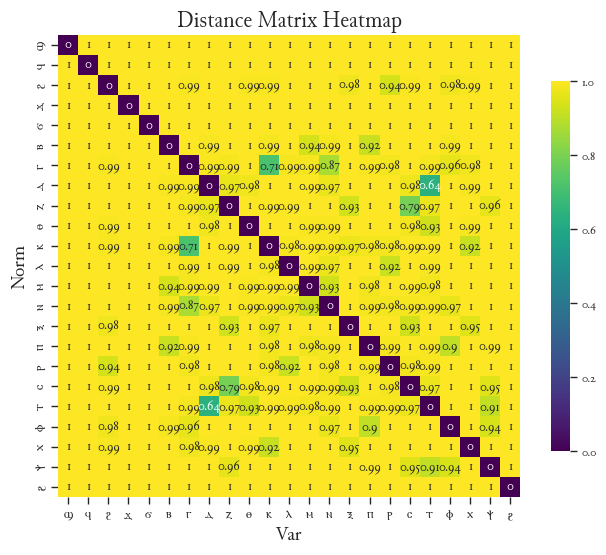

/tmp/ipykernel_421023/745626487.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


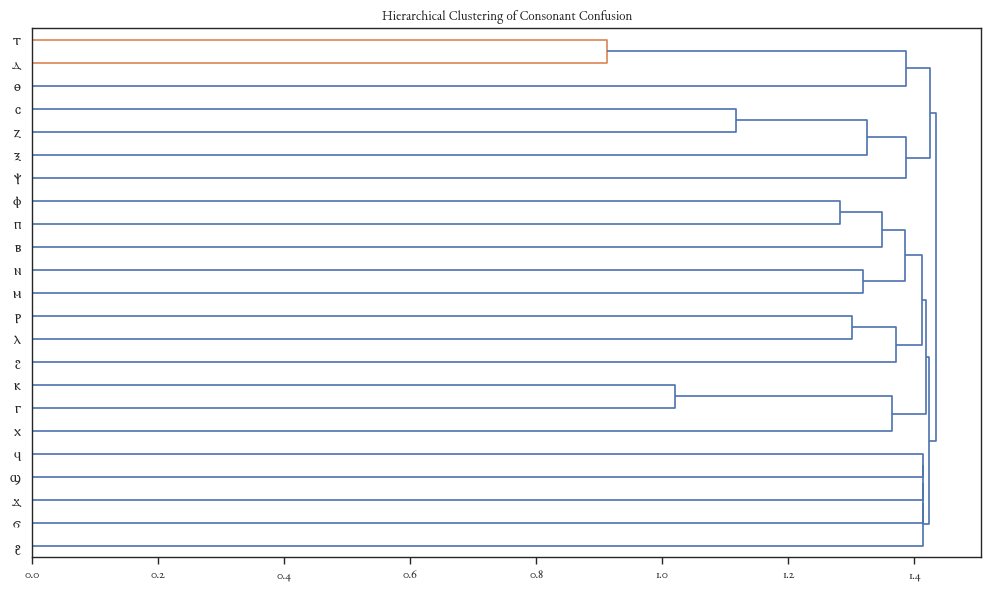

In [1371]:
norm_confusion = consonant_frequency.copy().astype(float)

for grapheme in norm_confusion.index:
    if grapheme in consonant_occurrences:
        total = consonant_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)
np.fill_diagonal(distance_matrix, 0)
distance_matrix[np.isnan(distance_matrix)] = 1
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Consonant Confusion")
plt.tight_layout()
plt.show()

In [1058]:
all_consonant_regularities = pd.DataFrame(consonant_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_consonant_frequencies  = pd.DataFrame(consonant_frequency.stack()).reset_index().rename(columns={0: "frequency"})
consonant_deviations = pd.merge(all_consonant_regularities, all_consonant_frequencies, on=["norm", "var"])
write_csv(consonant_deviations, "deviations-consonants")

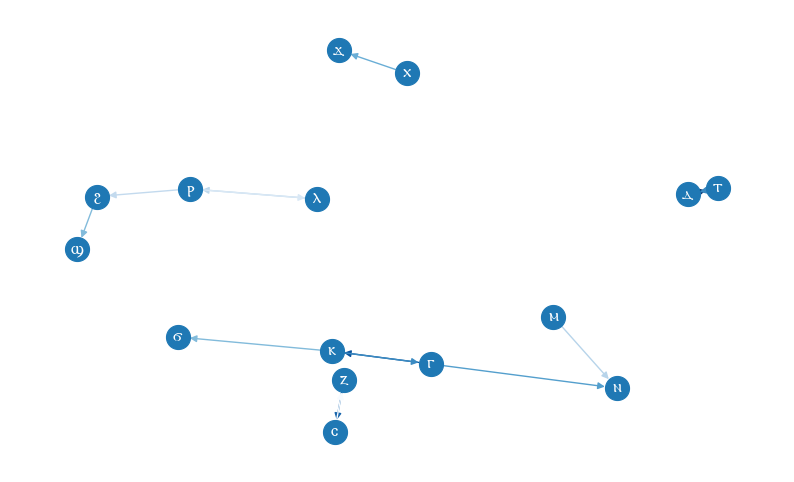

In [530]:
graph = nx.from_pandas_edgelist(
    consonant_deviations[consonant_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["frequency", "regularity"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, k=2.2, weight="frequency", seed=342)

fig = plt.figure(figsize=(10, 6))
nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(r) for r in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)
fig.savefig(subdirectory / "figure-consonants_graph.svg")
plt.show()

(300.0, 1272.6)

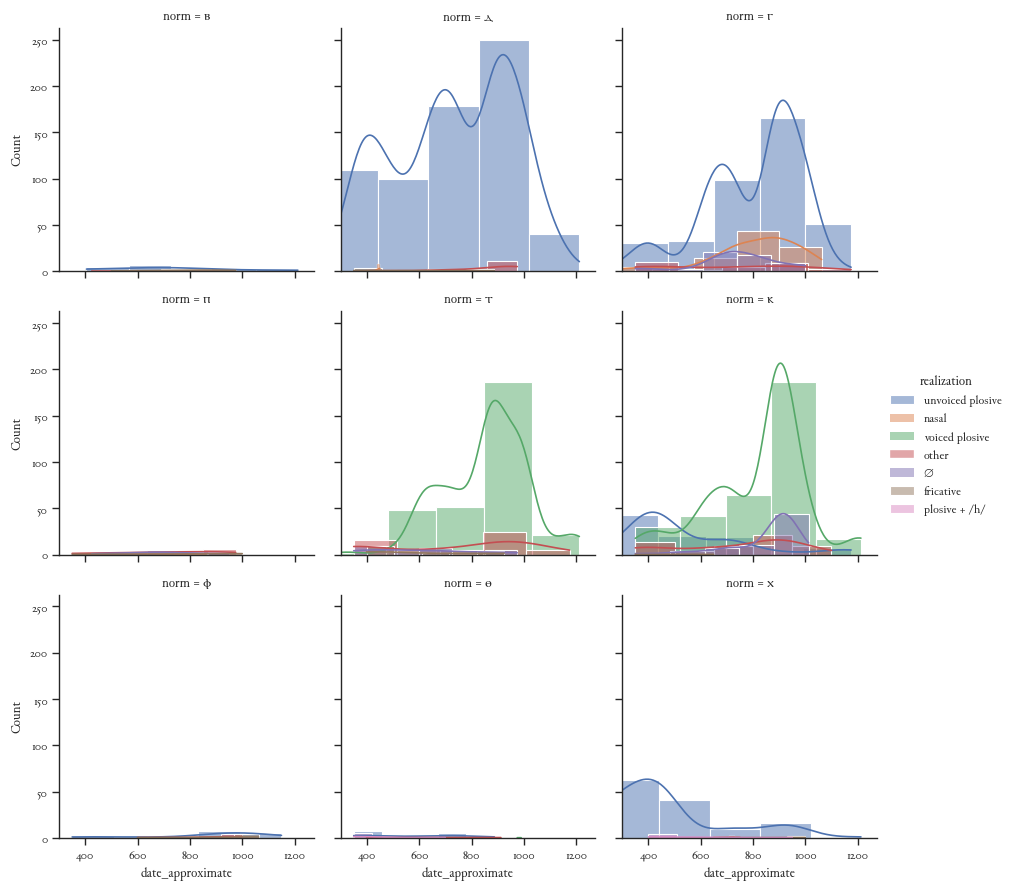

In [1512]:
stops = df_diff[df_diff["norm"].isin({"ⲃ", "ⲇ", "ⲅ", "ⲡ", "ⲧ", "ⲕ", "ⲫ", "ⲑ", "ⲭ"})].copy()
stops["realization"] = stops["var"].apply(lambda x: "unvoiced plosive" if x in {"ⲡ", "ⲧ", "ⲕ", "ϭ", "ϫ"} else "voiced plosive" if x in {"ⲇ", "ⲅ"} else "nasal" if x in {"ⲙ", "ⲛ"} else "plosive + /h/" if x in {"ⲡϩ", "ⲧϩ", "ⲕϩ"} else "fricative" if x in {"ⲃ", "ϩ", "ϥ", "ⲍ", "ⲥ", "ϣ"} else "∅" if x == "∅" else "other")

g = sns.FacetGrid(stops, col="norm", hue="realization", col_wrap=3, col_order=["ⲃ", "ⲇ", "ⲅ", "ⲡ", "ⲧ", "ⲕ", "ⲫ", "ⲑ", "ⲭ"])
g.map(sns.histplot, "date_approximate", kde=True, bins=5)
g.add_legend()
plt.xlim(300)

## What influences plosive deviation?

In [1304]:
def categorize(row):
    if row["shift_class"] == 'aspiration' and row["shift_origin"] == "nongreek":
        return "aspiration"
    elif row['shift_class'] == "voiced_voiceless":
        return "voicing"
    else:
        return "other"

xtab_aspiration = pd.crosstab(df_diff.apply(categorize, axis=1), df_diff.dialect_group == "B").rename(
    columns={ True: 'B', False: 'non-B' },
)

print(contingency_statistics(xtab_aspiration))

xtab_aspiration #/ expected

{'χ²': 95.81070801578957, 'p-value': 1.5666396026276611e-21, 'df': 2, 'V': 0.04574818555160529}


dialect_group,non-B,B
row_0,,
aspiration,183,36
other,39476,2419
voicing,3553,112


In [1305]:
chi2_deluxe(xtab_aspiration)

dialect_group,non-B,B
row_0,,
aspiration,"–, χ² = 2.72 n. s.","+, χ² = 45.82 ***"
other,"–, χ² = 0.12 n. s.","+, χ² = 2.07 n. s."
voicing,"+, χ² = 2.53 n. s.","–, χ² = 42.55 ***"


## What influences lambdacism?

In [636]:
xtab_lambdacism = pd.crosstab(
    df_diff['shift_class'] == "lambdacism",
    df_diff['dialect_group'].isin({"F"})
).rename(
    columns={False: "S/B/M/L/A", True: "F"}
)
print(contingency_statistics(xtab_lambdacism))
xtab_lambdacism

{'χ²': 7.676781774180608, 'p-value': 0.005593583477722507, 'DOF': 1, 'V': 0.013784978019257647}


dialect_group,S/B/M/L/A,F
shift_class,,
False,43411,2196
True,172,0


In [637]:
chi2_deluxe(xtab_lambdacism)

dialect_group,S/B/M/L/A,F
shift_class,,
False,"–, χ² = 0.00 n. s.","+, χ² = 0.03 n. s."
True,"+, χ² = 0.42 n. s.","–, χ² = 8.25 *"


# What influences aspiration?

In [1393]:
vowel = ("ⲁ", "ⲉ", "ⲓ", "ⲟ", "ⲩ", "ⲏ", "ⲱ")
vowel_or_spiritus = tuple([*vowel, *map(lambda x: "ϩ" + x, vowel)])

vocalic_initial = df_simple[df_simple["greek_lemma"].str.startswith(vowel_or_spiritus) & df_simple["orthography_clean"].str.startswith(vowel_or_spiritus)]

vocalic_initial = vocalic_initial.assign(
    greek_h=vocalic_initial["greek_lemma"].str.startswith("ϩ"),
    coptic_h=vocalic_initial["orthography_clean"].str.startswith("ϩ")
)
vocalic_initial["century"] = (vocalic_initial["date_approximate"] // 100)

pattern = re.compile(r"ⲁⲩ|ⲁⲓ|ⲉⲓ|ⲟⲩ|ⲟⲓ|ⲉⲩ|[ⲁⲉⲓⲟⲩⲏⲱ]")

def find_first_vowel(text):
    match = pattern.search(text)
    return match.group(0) if match else None

vocalic_initial["initial_vowel"] = vocalic_initial["greek_lemma"].apply(find_first_vowel)

In [1410]:
pd.crosstab(vocalic_initial["greek_h"], vocalic_initial["coptic_h"], normalize=True)

coptic_h,False,True
greek_h,,
False,0.818749,0.035869
True,0.013782,0.131599


In [1397]:
agreement = (vocalic_initial['greek_h'] == vocalic_initial['coptic_h']).mean()
agreement

0.9503485288747042

In [1430]:
xtab_initial_vowel = pd.crosstab(vocalic_initial["greek_lemma"], vocalic_initial.apply(lambda x: (x["greek_h"] == x["coptic_h"]), axis=1))
contingency_statistics(xtab_initial_vowel)
chi2_components = chi2_deluxe(xtab_initial_vowel)
chi2_components[chi2_components.apply(lambda row: row.astype(str).str.contains(r'\*').any(), axis=1)].sort_values(by=False)

col_0,False,True
greek_lemma,,
ⲓⲥⲟⲭⲣⲟⲛⲟⲥ,"+, χ² = 109.14 ***","–, χ² = 5.70 n. s."
ϩⲟⲑⲉⲛ,"+, χ² = 109.14 ***","–, χ² = 5.70 n. s."
ⲁⲅⲕⲩⲣⲁ,"+, χ² = 109.14 ***","–, χ² = 5.70 n. s."
ϩⲁⲗⲥ,"+, χ² = 109.76 ***","–, χ² = 5.73 n. s."
ϩⲩⲓⲟⲥ,"+, χ² = 1091.40 ***","–, χ² = 57.02 ***"
...,...,...
ⲉⲓⲧⲉ,"–, χ² = 55.41 ***","+, χ² = 2.89 n. s."
ⲁⲅⲁⲡⲏ,"–, χ² = 55.61 ***","+, χ² = 2.91 n. s."
ⲁⲓⲱⲛ,"–, χ² = 62.61 ***","+, χ² = 3.27 n. s."


/tmp/ipykernel_421023/1097576438.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(
/tmp/ipykernel_421023/1097576438.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(


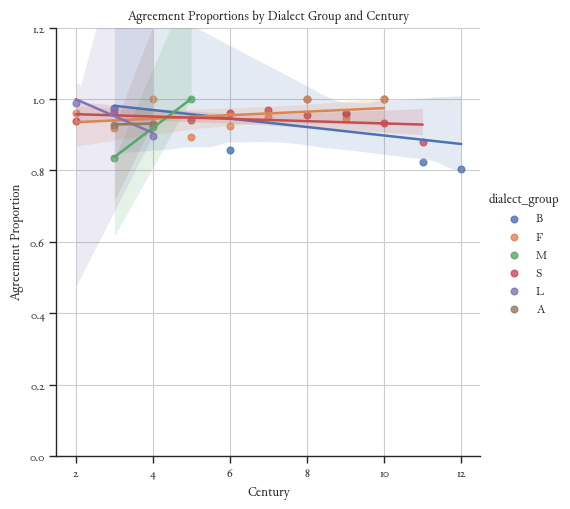

In [1417]:
agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(
    lambda x: (x["greek_h"] == x["coptic_h"]).mean()
).reset_index(name='agreement_proportion')

# Create the plot using lmplot
sns.lmplot(data=agreement_proportions, x='century', y='agreement_proportion', 
           hue='dialect_group', markers='o')

# Customize the plot
plt.title('Agreement Proportions by Dialect Group and Century')
plt.xlabel('Century')
plt.ylim(0, 1.2)
plt.ylabel('Agreement Proportion')
plt.grid(True)

# Show the plot
plt.show()

# TODO maybe this is due to bohairic using more words like hirēnē later on?

In [239]:
vocalic_initial[vocalic_initial['greek_h'] != vocalic_initial['coptic_h']]["greek_lemma"].unique()

array(['ⲉⲗⲡⲓⲍⲱ', 'ⲉⲗⲡⲓⲥ', 'ⲉⲓ', 'ϩⲁⲣⲙⲁ', 'ϩⲟⲣⲙⲓⲥⲕⲟⲥ', 'ϩⲱⲥ', 'ⲁⲙⲏⲛ',
       'ϩⲁⲅⲓⲟⲥ', 'ⲉⲓⲕⲱⲛ', 'ⲓⲥⲟⲥ', 'ⲉⲑⲛⲟⲥ', 'ϩⲟⲣⲁⲥⲓⲥ', 'ϩⲉⲱⲥ', 'ϩⲟⲥⲟⲥ',
       'ϩⲟⲧⲓ', 'ϩⲓⲛⲁ', 'ϩⲁⲗⲩⲥⲓⲥ', 'ⲓⲥⲁⲅⲅⲉⲗⲟⲥ', 'ⲉⲓⲣⲏⲛⲏ', 'ⲉⲧⲁⲍⲱ',
       'ϩⲩⲡⲁⲣⲭⲱ', 'ⲟⲣⲅⲏ', 'ⲟⲃⲟⲗⲟⲥ', 'ϩⲩⲇⲱⲣ', 'ϩⲟⲙⲟⲩ', 'ϩⲉⲕⲧⲟⲥ', 'ⲁⲣⲁ',
       'ⲏⲇⲏ', 'ϩⲩⲓⲟⲥ', 'ⲉⲛⲛⲉⲁⲥ', 'ⲉⲓⲗⲓⲕⲣⲓⲛⲏⲥ', 'ⲟⲅⲇⲟⲁⲥ', 'ϩⲉⲝⲁⲥ',
       'ϩⲏⲗⲓⲁⲕⲟⲥ', 'ϩⲩⲡⲉⲣⲁⲥⲁⲗⲉⲩⲧⲟⲥ', 'ⲱⲓⲇⲏ', 'ⲓⲇⲓⲟⲥ', 'ⲁⲅⲛⲉⲓⲁ',
       'ϩⲩⲡⲟⲭⲟⲛⲇⲣⲓⲟⲥ', 'ϩⲏⲗⲓⲟⲥ', 'ⲟⲗⲓⲅⲟⲥ', 'ϩⲏⲛⲓⲟⲭⲟⲥ', 'ϩⲉⲗⲗⲉⲃⲟⲣⲟⲥ',
       'ϩⲟⲧⲁⲛ', 'ϩⲉⲣⲙⲏⲛⲉⲩⲱ', 'ⲓⲇⲉⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲓⲁ', 'ⲓⲥⲟⲭⲣⲟⲛⲟⲥ', 'ⲉⲑⲛⲓⲕⲟⲥ',
       'ⲉⲓⲕⲟⲛⲓⲕⲟⲥ', 'ⲟⲡⲱⲣⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲟⲥ', 'ϩⲟⲓⲟⲥ', 'ϩⲱⲥⲁⲛⲛⲁ', 'ⲁⲣⲙⲁ',
       'ϩⲓⲉⲣⲁⲧⲓⲕⲟⲥ', 'ⲏⲧⲣⲟⲛ', 'ⲁⲙⲙⲁⲛⲓⲧⲏⲥ', 'ⲉⲑⲟⲥ', 'ϩⲏⲥⲩⲭⲁⲍⲱ', 'ϩⲟⲙⲟⲓⲟⲥ',
       'ϩⲉⲧⲟⲓⲙⲟⲥ', 'ϩⲁⲅⲓⲱⲥⲩⲛⲏ', 'ϩⲁⲡⲗⲱⲥ', 'ϩⲉⲃⲇⲟⲙⲁⲥ', 'ⲁⲛⲁⲗⲱⲙⲁ', 'ⲟⲕⲛⲟⲥ',
       'ⲉⲑⲱ', 'ϩⲉⲯⲏⲙⲁ', 'ϩⲁⲗⲱⲛⲓⲁ', 'ⲓⲇⲓⲱⲧⲏⲥ', 'ⲁⲛⲁⲅⲛⲱⲥⲧⲏⲥ', 'ϩⲟⲙⲟⲗⲟⲅⲓⲁ',
       'ⲓⲁⲧⲣⲟⲥ', 'ϩⲏⲙⲓⲥⲩⲥ', 'ϩⲉⲕⲁⲧⲟⲛ', 'ϩⲉⲝⲏⲕⲟⲛⲧⲁ', 'ϩⲉⲝⲁⲕⲉⲣⲁⲧⲓⲟⲛ',
       'ⲉⲕⲭⲱⲣⲏⲧⲓⲕⲟⲥ', 'ϩⲁⲗⲁⲧⲓⲟⲛ', 'ⲁⲗⲉⲩⲣⲟⲛ', 'ϩⲩⲡⲟⲡⲟⲇⲓⲟⲛ', 'ϩⲟⲥⲓⲟⲥ',
       'ϩⲟⲓⲟⲥⲇⲏⲡⲟⲧⲉ'

In [1310]:
xtab_vulgar_aspiration = pd.crosstab(
    df_diff.apply(deviation_operates_in({"∅", "ϩ"}), axis=1),
    df_diff['dialect_group']
).rename(
    columns={False: "S/B/M/L/A", True: "F"}
)
print(contingency_statistics(xtab_vulgar_aspiration))
xtab_vulgar_aspiration

{'χ²': 751.6042518613467, 'p-value': 3.4020867519257683e-160, 'df': 5, 'V': 0.1281331383173286}


dialect_group,B,F,M,S,L,A
row_0,,,,,,
False,2159,2091,1223,34548,1472,477
True,408,105,306,2704,138,148


In [647]:
chi2_deluxe(xtab_vulgar_aspiration)

dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,"–, χ² = 16.06 **","+, χ² = 3.00 n. s.","–, χ² = 22.80 ***","+, χ² = 4.58 n. s.","–, χ² = 0.01 n. s.","–, χ² = 16.08 **"
ϩ→∅,"+, χ² = 1519.71 ***","–, χ² = 21.26 ***","–, χ² = 8.50 n. s.","–, χ² = 74.18 ***","–, χ² = 3.10 n. s.","+, χ² = 12.42 **"
∅→ϩ,"–, χ² = 22.75 ***","–, χ² = 16.92 ***","+, χ² = 369.63 ***","–, χ² = 13.04 **","+, χ² = 1.64 n. s.","+, χ² = 172.47 ***"


<Axes: xlabel='date_approximate', ylabel='Count'>

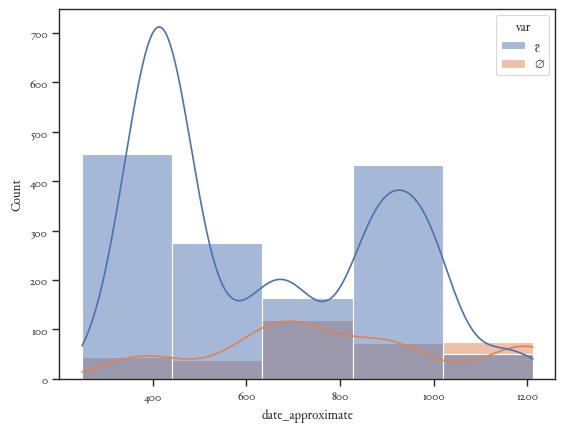

In [1439]:
un_aspiration = df_diff[((df_diff["norm"] == "ϩ") & (df_diff["var"] == "∅")) | ((df_diff["norm"] == "∅") & (df_diff["var"] == "ϩ"))].copy()
sns.histplot(data=un_aspiration, x='date_approximate', hue='var', bins=5, kde=True)

# Epenthesis

<Axes: >

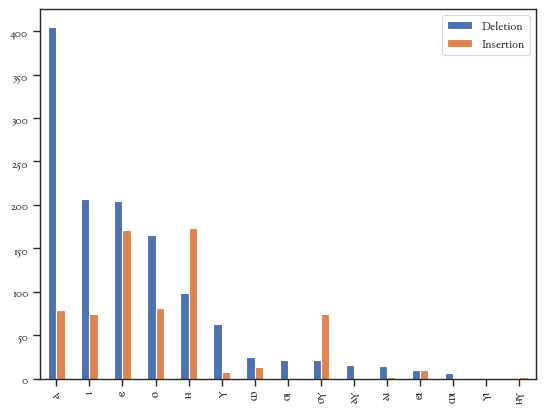

In [1520]:
unique_by_orthography = df_diff

deletions = unique_by_orthography[(unique_by_orthography["var"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]
insertions = unique_by_orthography[(unique_by_orthography["norm"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]

interesting = (vowels | diphthongs) - {"ϩ", "ⲥ", "ⲣ"}

pd.DataFrame({
    "Deletion": deletions[deletions["norm"].isin(interesting)]["norm"].value_counts(),
    "Insertion": insertions[insertions["var"].isin(interesting)]["var"].value_counts()
}).sort_values("Deletion", ascending=False).plot.bar(logy=False)

<Axes: xlabel='date_approximate', ylabel='Count'>

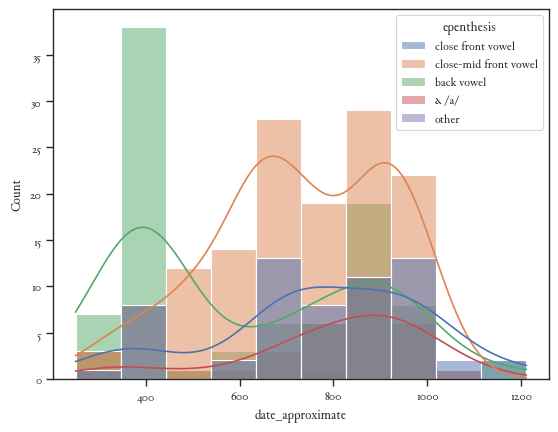

In [1534]:
interesting_insertions = insertions[insertions["var"].isin(interesting)].copy()
interesting_insertions["epenthesis"] = interesting_insertions["var"].apply(lambda x: "close front vowel" if x in {"ⲓ", "ⲩ", "ⲉⲓ"} else "close-mid front vowel" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "back vowel" if x in {"ⲱ", "ⲟ", "ⲟⲩ"} else "ⲁ /a/" if x in {"ⲁ"} else "other")
sns.histplot(interesting_insertions, hue="epenthesis", x="date_approximate", kde=True)#(interesting_insertions["var"], interesting_insertions["century"]).style.background_gradient(axis=None, cmap=cm)

In [1547]:
xtab_epenthesis = pd.crosstab(df_diff.apply(lambda row: (row["norm"] == "∅") and row["var"] in (vowels), axis=1), df_diff["date_approximate"] > 710).rename(
    columns={True: "Arab era", False: "pre-Arab era"},
    index={True: "vocalic epenthesis", False: "other"}
)
print(contingency_statistics(xtab_epenthesis))
xtab_epenthesis

{'χ²': 3.9550037543239656, 'p-value': 0.04673221392452215, 'df': 1, 'V': 0.0094988929302872}


date_approximate,pre-Arab era,Arab era
row_0,,
other,31857,13281
vocalic epenthesis,476,165


In [1551]:
xtab_epenthesis = pd.crosstab(df_diff.apply(lambda row: (row["norm"] == "∅") and row["var"] in (vowels | diphthongs), axis=1), df_diff["dialect_group"]).rename(
    columns={True: "B", False: "non-B"},
    index={True: "vocalic epenthesis", False: "other"}
)
print(contingency_statistics(xtab_epenthesis))
xtab_epenthesis

{'χ²': 138.58423283006525, 'p-value': 3.577443129165947e-28, 'df': 5, 'V': 0.0550204021245764}


dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,2467,2149,1477,36750,1586,619
vocalic epenthesis,100,47,52,502,24,6


In [1552]:
chi2_deluxe(xtab_epenthesis)

dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,"–, χ² = 1.38 n. s.","–, χ² = 0.07 n. s.","–, χ² = 0.51 n. s.","+, χ² = 0.24 n. s.","+, χ² = 0.00 n. s.","+, χ² = 0.03 n. s."
vocalic epenthesis,"+, χ² = 84.95 ***","+, χ² = 4.06 n. s.","+, χ² = 31.17 ***","–, χ² = 14.49 **","–, χ² = 0.11 n. s.","–, χ² = 1.59 n. s."


# Older words — older pronunciations

In [249]:
# Group by both 'greek_lemma' and 'dialect_group' to get the minimum date
date_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()

# Count deviations per lemma and dialect group
deviations_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Count attestations per lemma and dialect group
attestations_per_lemma = df_simple.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Create a DataFrame with the results
per_lemma = pd.DataFrame({
    "earliest_attestation": date_per_lemma,
    "deviations": deviations_per_lemma,
    "attestations": attestations_per_lemma
}).dropna()

# Calculate the deviation rate
per_lemma["deviation_rate"] = per_lemma["deviations"].div(per_lemma["attestations"])

# Reset index to make 'greek_lemma' and 'dialect_group' columns
per_lemma = per_lemma.reset_index()
per_lemma

/tmp/ipykernel_421023/1887153394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()
/tmp/ipykernel_421023/1887153394.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()
/tmp/ipykernel_421023/1887153394.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

,greek_lemma,dialect_group,earliest_attestation,deviations,attestations,deviation_rate
0,ϩⲁⲅⲁⲣⲓⲛⲛⲁⲓⲟⲥ,B,1212.0,2.0,1,2.000000
1,ϩⲁⲅⲓⲁⲍⲱ,S,949.5,3.0,18,0.166667
2,ϩⲁⲅⲓⲟⲥ,B,699.5,31.0,178,0.174157
3,ϩⲁⲅⲓⲟⲥ,S,649.5,6.0,943,0.006363
4,ϩⲁⲅⲓⲱⲥⲩⲛⲏ,S,612.0,14.0,31,0.451613
...,...,...,...,...,...,...
2302,ⲱⲕⲉⲁⲛⲟⲥ,S,949.5,3.0,10,0.300000
2303,ⲱⲙⲟⲫⲟⲣⲟⲥ,L,404.0,1.0,10,0.100000
2304,ⲱⲛⲏⲙⲁ,S,749.5,2.0,1,2.000000
2305,ⲱⲫⲉⲗⲉⲱ,S,699.5,6.0,65,0.092308


SignificanceResult(statistic=-0.08560549184198107, pvalue=3.837216634107027e-05)

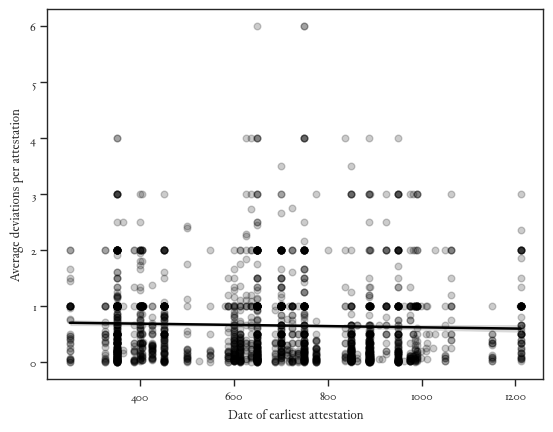

In [538]:
sns.regplot(x="earliest_attestation", y="deviation_rate", data=per_lemma, scatter_kws={'alpha':0.2}, color="black")
plt.ylabel("Average deviations per attestation")
plt.xlabel("Date of earliest attestation")
write_figure("deviation_rate_by_earliest_attestation")
scipy.stats.spearmanr(per_lemma["earliest_attestation"], per_lemma["deviation_rate"])

***

# Misc

In [251]:
import math
interesting = vowels | diphthongs | consonants | {"∅"}

sound_frequency = {x: df_diff["greek_lemma"].str.count(x).sum() for x in interesting}
def func(group): 
    norm = group["norm"].unique()[0]
    if sound_frequency[norm] == 0:
        return 0.01
    else:
        return group.shape[0] / sound_frequency[norm]

def classify_deviation(deviation):
    norm, var = deviation.split("→")
    return {"norm": norm, "var": var}

sounds_affected = df_diff[df_diff["norm"].isin(interesting)].groupby("deviation").apply(func)
words_affected = df_diff.groupby("deviation")["greek_lemma"].unique().apply(len)#.apply(math.log10)
absolute_frequency = df_diff.groupby("deviation")["deviation"].apply(len)
relative_frequency_df = pd.DataFrame(words_affected.rename("Word rate")).join(sounds_affected.rename("Sound rate")).join(absolute_frequency.rename("Absolute frequency"))
relative_frequency_df["Word spread"] = relative_frequency_df["Word rate"].div(relative_frequency_df["Absolute frequency"])
relative_frequency_df["Score"] = relative_frequency_df["Word rate"].mul(relative_frequency_df["Sound rate"])
relative_frequency_df = relative_frequency_df[~relative_frequency_df.index.isin(morphological_lapsus)]
relative_frequency_df[['shift_class', 'shift_origin']] = pd.DataFrame(
    relative_frequency_df.index.map(classify_deviation).tolist(), 
    index=relative_frequency_df.index
)


/tmp/ipykernel_421023/1374619051.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sounds_affected = df_diff[df_diff["norm"].isin(interesting)].groupby("deviation").apply(func)


In [252]:
relative_frequency_df[~relative_frequency_df["shift_class"].isnull()].sort_values(by="Score", ascending=False)#["class"]#.value_counts()

,Word rate,Sound rate,Absolute frequency,Word spread,Score,shift_class,shift_origin
deviation,,,,,,,
ⲉⲓ→ⲓ,196,0.594507,4784,0.040970,116.523425,ⲉⲓ,ⲓ
ⲇ→ⲧ,201,0.212967,1465,0.137201,42.806367,ⲇ,ⲧ
ⲁⲓ→ⲉ,119,0.317614,1448,0.082182,37.796008,ⲁⲓ,ⲉ
ⲟ→ⲱ,459,0.060241,1953,0.235023,27.650432,ⲟ,ⲱ
ⲅ→ⲕ,221,0.117916,801,0.275905,26.059326,ⲅ,ⲕ
...,...,...,...,...,...,...,...
ⲱⲥ→∅,1,NaN,1,1.000000,NaN,ⲱⲥ,∅
ⲱⲥ→ⲟⲩ,1,NaN,1,1.000000,NaN,ⲱⲥ,ⲟⲩ
ⲱⲥⲓⲥ→∅,1,NaN,3,0.333333,NaN,ⲱⲥⲓⲥ,∅


/tmp/ipykernel_421023/3514902429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  greek_tokens_per_century = (df_diff.groupby('dialect_group')['century']).value_counts()


dialect_group  century
B              10.0       432
               7.0        338
               4.0        301
               13.0       273
               12.0       184
                         ... 
A              9.0          0
               10.0         0
               11.0         0
               12.0         0
               13.0         0
Name: count, Length: 66, dtype: int64

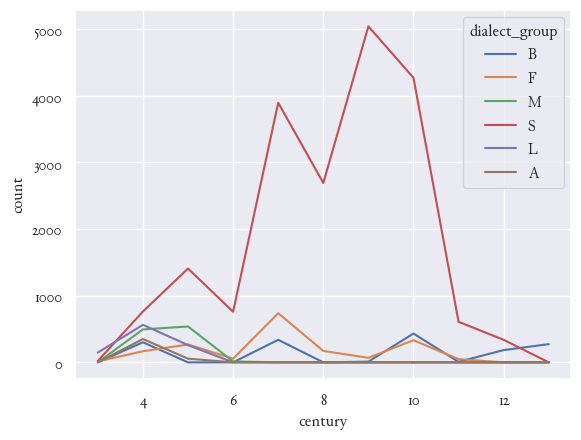

In [253]:
greek_tokens_per_century = (df_diff.groupby('dialect_group')['century']).value_counts()
sns.lineplot(greek_tokens_per_century.reset_index(), x="century", hue="dialect_group", y="count")
greek_tokens_per_century

In [254]:
interesting_dialects = {"S", "B", "F"}

deviations = df_diff_well_dated.groupby(['dialect_group', 'century', 'shift_class', 'shift_origin']).size().reset_index(name='deviation_count')
deviations = deviations.merge(greek_tokens_per_century.rename("greek_token_count"), on=["dialect_group", "century"])
deviations["deviation_count_relative"] = deviations["deviation_count"].div(deviations["greek_token_count"])
deviations = deviations.dropna()
deviations.sample(10)

/tmp/ipykernel_421023/4098691032.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations = df_diff_well_dated.groupby(['dialect_group', 'century', 'shift_class', 'shift_origin']).size().reset_index(name='deviation_count')


,dialect_group,century,shift_class,shift_origin,deviation_count,greek_token_count,deviation_count_relative
834,S,4.0,reduction,greek,0,763,0.000000
237,B,12.0,spirantisation,nongreek,0,184,0.000000
968,S,10.0,gemination,greek,0,4268,0.000000
1067,L,3.0,lambdacism,nongreek,0,147,0.000000
880,S,6.0,palatalisation,greek,0,759,0.000000
986,S,11.0,back_vowel,greek,41,608,0.067434
582,M,5.0,front_vowel,greek,64,538,0.118959
830,S,4.0,nasal,greek,0,763,0.000000
840,S,5.0,aspiration,greek,0,1407,0.000000
1116,L,5.0,monophthongization,greek,21,258,0.081395


In [255]:
deviations['shift_class'].value_counts()

shift_class
aspiration            68
back_vowel            68
epenthesis            68
front_vowel           68
gemination            68
lambdacism            68
monophthongization    68
nasal                 68
palatalisation        68
reduction             68
spirantisation        68
voiced_voiceless      68
Name: count, dtype: int64

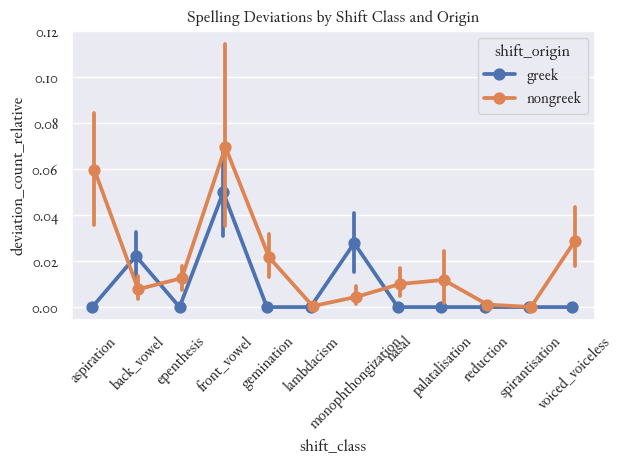

In [256]:
sns.pointplot(
    data=deviations,
    x="shift_class",
    y="deviation_count_relative",
    hue="shift_origin",
    dodge=True
)
plt.xticks(rotation=45)
plt.title("Spelling Deviations by Shift Class and Origin")
plt.tight_layout()
plt.show()


<Axes: xlabel='date_approximate', ylabel='Count'>

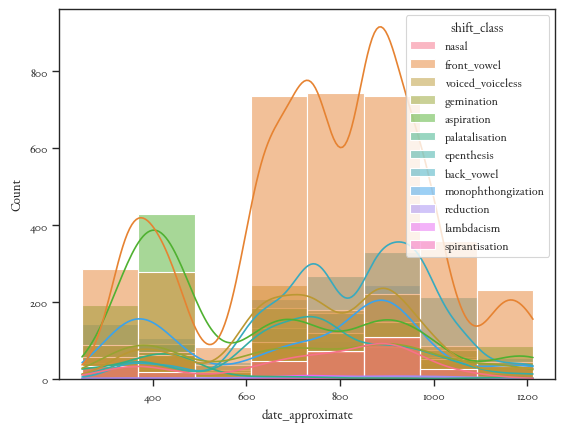

In [543]:
sns.histplot(df_diff_well_dated, x="date_approximate", hue="shift_class", kde=True, bins=8)

<Figure size 1000x600 with 0 Axes>

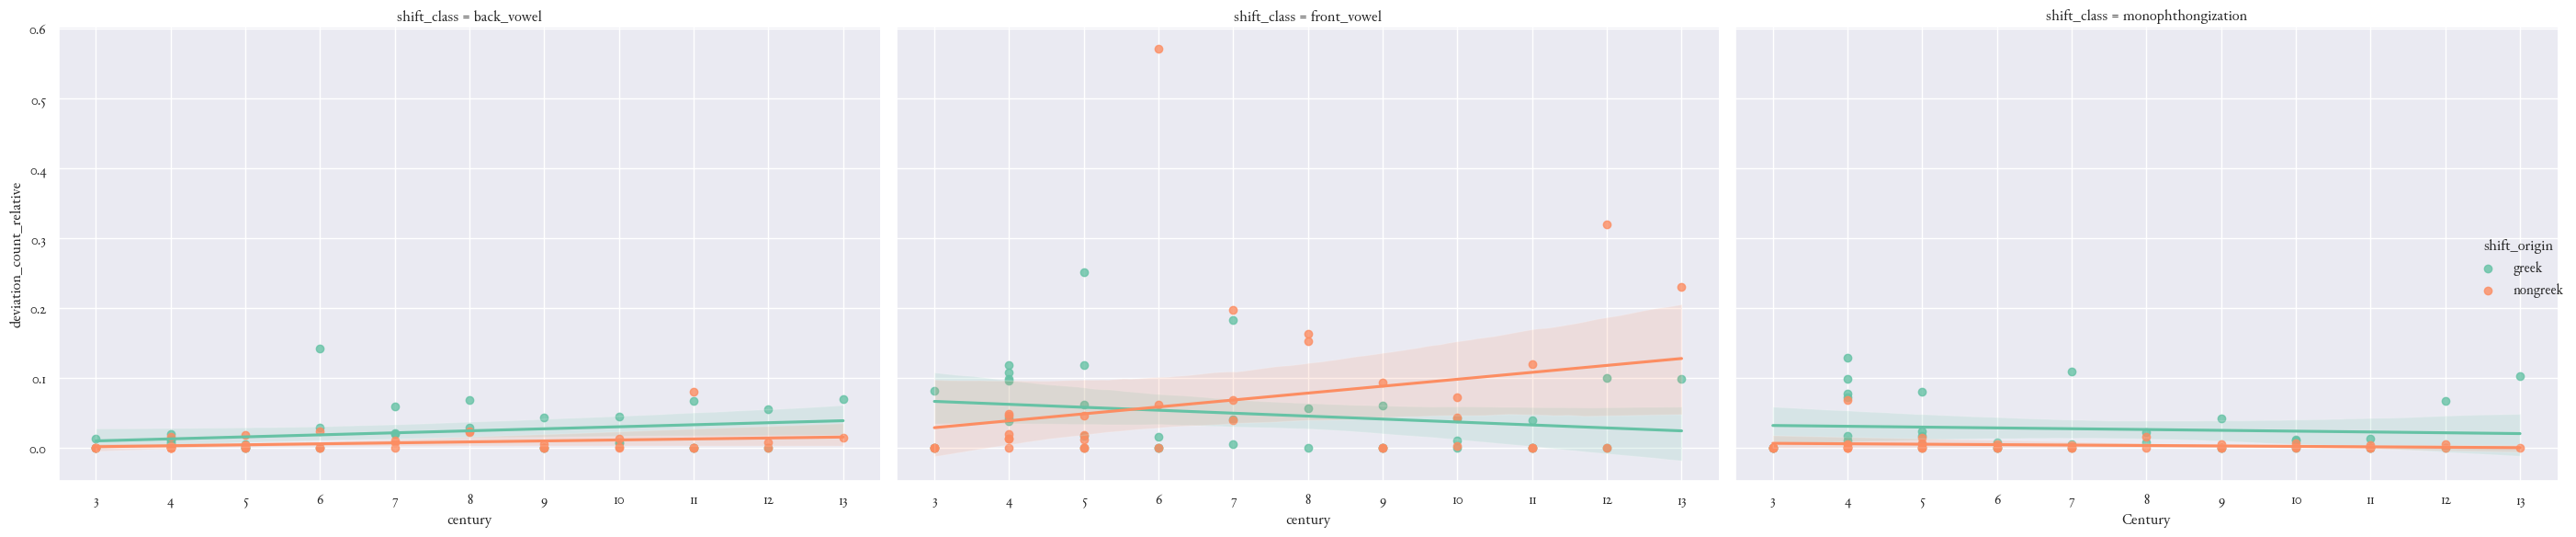

In [257]:

plt.figure(figsize=(10, 6))
sns.lmplot(data=deviations[deviations["shift_class"].isin({"monophthongization", "front_vowel", "back_vowel"})], x='century', y='deviation_count_relative', hue='shift_origin',
           markers='o', aspect=1.5, height=6, palette='Set2', col='shift_class')

#plt.yscale('log')
plt.xlabel("Century")
plt.ylabel("Frequency")
plt.xticks(deviations['century'].unique())  # Ensure all centuries are shown on the x-axis
plt.tight_layout()
plt.show()

## Spelling of common words is more consistent

/tmp/ipykernel_421023/2063160933.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frequency_df = pd.DataFrame({"occurrences": df_simple["greek_lemma"].value_counts(), "deviations": df_diff["greek_lemma"].value_counts(), "entropy": df_simple.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))


<Axes: xlabel='occurrences', ylabel='entropy'>

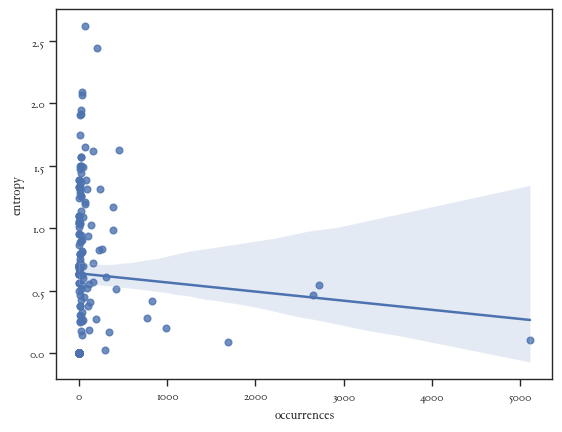

In [1519]:
frequency_df = pd.DataFrame({"occurrences": df_simple["greek_lemma"].value_counts(), "deviations": df_diff["greek_lemma"].value_counts(), "entropy": df_simple.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))
}).dropna().sample(200)
#scipy.stats.spearmanr()

sns.regplot(y=frequency_df["entropy"], x=frequency_df["occurrences"])


## Vowel confusion is more likely at right word edge?

<Axes: >

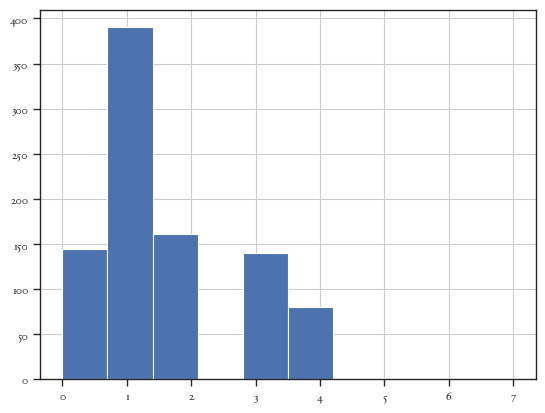

In [1159]:
df_diff[df_diff["norm"].isin({"ⲁ", "ⲟ", "ⲉ"}) & df_diff["var"].isin({"ⲁ", "ⲟ", "ⲉ"})]["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()

<Axes: >

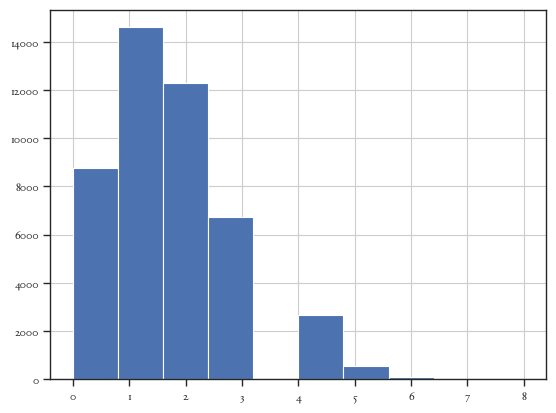

In [1160]:
df_diff["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()